<a href="https://colab.research.google.com/github/mustafabozkaya/Deep_Learning_Bootcamp/blob/master/AI/ML%20Challenge/eye_Vgg19model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download images into colab 

In [7]:
from google.colab import drive
drive.mount('/content/mydrive/',force_remount=True)

Mounted at /content/mydrive/


In [8]:
%pwd

'/content'

In [ ]:
!unzip "/content/mydrive/MyDrive/eye_gender_data.zip" -d "/content/datasets/"

## Import libraries

In [16]:
from __future__ import print_function
import PIL
import PIL.Image
import tensorflow_datasets as tfds

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import glob
import numpy as np
import os
import shutil
import pathlib
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"]=(18,8)
%matplotlib inline
np.random.seed(42)

## Loading and preparing training data


In [17]:
train_labels = pd.read_csv("/content/datasets/eye_gender_data/Training_set.csv") 
test_labels = pd.read_csv("/content/datasets/eye_gender_data/Testing_set.csv") 
submission= pd.read_csv("/content/datasets/eye_gender_data/sample_submission.csv") 

In [19]:
train_labels.head()

,filename,label
0,Image_1.jpg,male
1,Image_2.jpg,female
2,Image_3.jpg,female
3,Image_4.jpg,female
4,Image_5.jpg,male


In [20]:
test_labels.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [21]:
submission.head()

,label
0,male
1,male
2,male
3,male
4,male


In [22]:
!ls


datasets  mydrive  sample_data


In [84]:

train_dataset_dir=f"/content/datasets/eye_gender_data/train"



In [41]:
data_dir = pathlib.Path(train_dataset_dir)
image_count = len(list(data_dir.glob('*_*.jpg')))
print(image_count)

9220


In [61]:
spec = list(data_dir.glob('*.jpg'))
img=PIL.Image.open(str(spec[9])).resize((128,128))

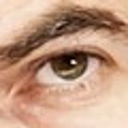

In [62]:
img

In [63]:
imgarr=np.array(img)
imgarr.shape

(128, 128, 3)

In [64]:

file_paths = [[fname, '/content/datasets/eye_gender_data/train/' + fname] for fname in train_labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
train_data = pd.merge(images, train_labels, how = 'inner', on = 'filename')


In [65]:
train_data.head()

,filename,filepaths,label
0,Image_1.jpg,/content/datasets/eye_gender_data/train/Image_...,male
1,Image_2.jpg,/content/datasets/eye_gender_data/train/Image_...,female
2,Image_3.jpg,/content/datasets/eye_gender_data/train/Image_...,female
3,Image_4.jpg,/content/datasets/eye_gender_data/train/Image_...,female
4,Image_5.jpg,/content/datasets/eye_gender_data/train/Image_...,male


## Data Pre-processing
It is necessary to bring all the images to the same shape and size as defined by the VGG-19 model. Also, convert all the labels from categorical to numerical values.

In [75]:
print(f" img lenth :{len(train_data)}")
train_imgs = [cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE) for img in train_data]
train_imgs = [cv.resize(img, (60,60)) for img in train_imgs]
train_imgs = np.array(train_imgs)
print('Train dataset shape:', train_imgs.shape)


 img lenth :9220
Train dataset shape: (3, 60, 60)


In [76]:
# reshape into 3 channels for feeding into the model
train_images_3ch = np.stack([train_imgs]*3, axis=-1)
print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype))


Train_images.shape: (3, 60, 60, 3), of uint8


In [77]:
# normalisation
train_images_scaled = train_images_3ch / 255.

In [78]:
# encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_labels = le.fit_transform(train_data[['label']])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [79]:
train_labels.shape

(9220,)

## Building Model & Hyperparameter tuning


In [80]:
# Build VGG19 Model

# define input shape
INPUT_SHAPE = (60, 60, 3)

# get the VGG19 model
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, 
                                               input_shape=INPUT_SHAPE) 

vgg_layers.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 60, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 60, 60, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 60, 60, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 30, 30, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 30, 30, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 30, 30, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 15, 15, 128)       0     

In [81]:
# Fine-tune all the layers
for layer in vgg_layers.layers:
    layer.trainable = True 

# Check the trainable status of the individual layers
for layer in vgg_layers.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f5d70335b50> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f5d70335ed0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f5d70305050> True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f5d70305510> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f5d703a8590> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f5d703a8a10> True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f5d7692fb10> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f5d703f9a50> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f5d703f10d0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f5d70311950> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f5d703288d0> True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f5d703158d0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f5d70327a50> True
<keras.layers.convolutional.conv2d.

In [82]:
# Build CNN model on top of VGG19

# define sequential model
model = tf.keras.models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_layers)

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #single node with ‘sigmoid‘ activation

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [83]:
EPOCHS = 30

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(train_images_scaled, train_labels,
                    batch_size=256,
                    callbacks=[es_callback], 
                    validation_split=0.1, epochs=EPOCHS, 
                    verbose=1)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 0.6644 - accuracy: 0.5000 - val_loss: 1.1030 - val_accuracy: 0.0000e+00
Epoch 2/30
1/1 [==============================] - 1s 540ms/step - loss: 0.8504 - accuracy: 0.5000 - val_loss: 1.0111 - val_accuracy: 0.0000e+00
Epoch 3/30
1/1 [==============================] - 1s 543ms/step - loss: 0.6888 - accuracy: 0.5000 - val_loss: 0.9420 - val_accuracy: 0.0000e+00
Epoch 4/30
1/1 [==============================] - 1s 541ms/step - loss: 1.1544 - accuracy: 0.0000e+00 - val_loss: 0.9221 - val_accuracy: 0.0000e+00
Epoch 5/30
1/1 [==============================] - 1s 546ms/step - loss: 0.5309 - accuracy: 0.5000 - val_loss: 0.8778 - val_accuracy: 0.0000e+00
Epoch 6/30
1/1 [==============================] - 1s 529ms/step - loss: 0.7190 - accuracy: 0.5000 - val_loss: 0.8440 - val_accuracy: 0.0000e+00
Epoch 7/30
1/1 [==============================] - 1s 537ms/step - loss: 0.3506 - accuracy: 1.0000 - val_loss: 0.8133 - val_accuracy: 0.

## Validate the model


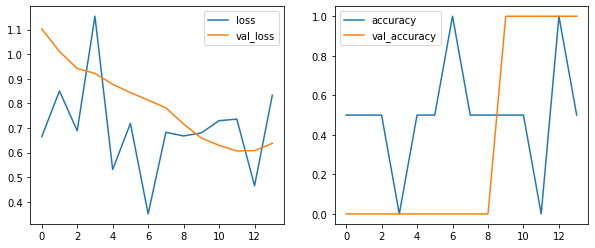

In [85]:
# Plot Learning Curves
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [ ]:
# saving the model
save_dir = "/results/"
model_name = 'eye_model.h5'
model.save(model_name)
model_path = save_dir + model_name
print('Saved trained model at %s ' % model_path)

Saved trained model at /results/eye_model.h5 


## Predict The Output For Testing Dataset

## Load Test Set

In [ ]:
test_labels = pd.read_csv("/content/datasets/eye_gender_data/Testing_set.csv") 
test_dataset_dir=f"/content/datasets/eye_gender_data/test"
file_paths_test = [[fname, test_dataset_dir + fname] for fname in test_data['filename']]
images_test = pd.DataFrame(file_paths_test, columns=['filename', 'filepaths'])

new_test_data = []
#image_size = 32 

for i in range(len(images_test)):
  
  img_array_test = cv2.imread(images_test['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale
  new_img_array_test = cv2.resize(img_array_test, (image_size, image_size))      # resizing the image array
  new_test_data.append(new_img_array_test)

## Data Pre-processing on test_data


In [ ]:
test_arr = np.array(new_test_data)

In [ ]:
test_arr

array([[[138, 140, 142, ..., 162, 167, 168],
        [140, 134, 137, ..., 159, 162, 161],
        [115, 131, 127, ..., 159, 158, 153],
        ...,
        [151, 164, 171, ..., 171, 159, 157],
        [147, 159, 165, ..., 166, 159, 154],
        [151, 160, 168, ..., 161, 150, 148]],

       [[163, 172, 156, ...,  84,  93,  85],
        [148, 158, 144, ...,  77,  75,  69],
        [136, 142, 128, ...,  67,  66,  68],
        ...,
        [114, 109, 108, ..., 129, 134, 144],
        [116, 119, 124, ..., 120, 134, 136],
        [112, 124, 123, ..., 120, 131, 122]],

       [[206, 200, 193, ..., 169, 176, 184],
        [205, 203, 186, ..., 171, 175, 180],
        [201, 202, 183, ..., 150, 156, 164],
        ...,
        [216, 218, 215, ..., 211, 214, 218],
        [215, 217, 218, ..., 215, 219, 222],
        [212, 217, 217, ..., 214, 220, 221]],

       ...,

       [[146, 149, 151, ..., 139, 142, 143],
        [150, 151, 155, ..., 139, 140, 140],
        [151, 150, 154, ..., 138, 139, 138

In [ ]:
test_arr.shape

(2305, 32, 32)

In [ ]:
# reshape into 3 channels for feeding into the model
test_images_3ch = np.stack([test_arr]*3, axis=-1)
print('\nTest_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype))


Test_images.shape: (2305, 32, 32, 3), of uint8


In [ ]:
# normalisation
test_images_scaled = test_images_3ch / 255.

## Make Prediction on Test Dataset

In [ ]:
test_predictions = model.predict(test_images_scaled)

In [ ]:
images_test['predictprobability'] = test_predictions

In [ ]:
def convert_to_label (row):
  if row['predictprobability'] >=0.5:
    return 'male'
  else:
    return 'female'

images_test['predictlabel'] = images_test.apply(convert_to_label, axis=1)

In [ ]:
images_test.head()

,filename,filepaths,predictprobability,predictlabel
0,Image_1.jpg,/content/content/eye_gender_data/test/Image_1.jpg,0.999559,male
1,Image_2.jpg,/content/content/eye_gender_data/test/Image_2.jpg,0.939506,male
2,Image_3.jpg,/content/content/eye_gender_data/test/Image_3.jpg,0.992196,male
3,Image_4.jpg,/content/content/eye_gender_data/test/Image_4.jpg,0.995121,male
4,Image_5.jpg,/content/content/eye_gender_data/test/Image_5.jpg,0.999794,male


In [ ]:
images_test.tail()

,filename,filepaths,predictprobability,predictlabel
2300,Image_2301.jpg,/content/content/eye_gender_data/test/Image_23...,0.015451,female
2301,Image_2302.jpg,/content/content/eye_gender_data/test/Image_23...,0.004437,female
2302,Image_2303.jpg,/content/content/eye_gender_data/test/Image_23...,0.999947,male
2303,Image_2304.jpg,/content/content/eye_gender_data/test/Image_23...,0.999949,male
2304,Image_2305.jpg,/content/content/eye_gender_data/test/Image_23...,0.917629,male


In [ ]:
# Save prediction results locally via colab notebook
images_test.to_csv("images_test.csv", index = False) 

# To download the csv file locally
from google.colab import files        
files.download('images_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>